In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import RandomizedSearchCV  # Import RandomizedSearchCV
import joblib
import warnings

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor


# Suppress only ConvergenceWarnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
import pickle


# 1. Data Exploration and Preprocessing

## 1.1 Loading and Initial Inspection

In [3]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)

In [4]:
# Read the data
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# Concatenate the two DataFrames while preserving their original indices
df = pd.concat([df_train, df_test], axis=0).reset_index(drop=False)


# Create a dictionary explaining each variable (for convinience only)
columns_explanation = {
    "SalePrice":"Sale price",
    "MSSubClass": "Identifies the type of dwelling involved in the sale, categorized by construction age and style: 20 (1-STORY 1946 & NEWER), 30 (1-STORY 1945 & OLDER), 40 (1-STORY W/FINISHED ATTIC), 45 (1-1/2 STORY - UNFINISHED), 50 (1-1/2 STORY FINISHED), 60 (2-STORY 1946 & NEWER), 70 (2-STORY 1945 & OLDER), 75 (2-1/2 STORY), 80 (SPLIT OR MULTI-LEVEL), 85 (SPLIT FOYER), 90 (DUPLEX), 120 (1-STORY PUD 1946 & NEWER), 150 (1-1/2 STORY PUD), 160 (2-STORY PUD 1946 & NEWER), 180 (PUD MULTILEVEL), 190 (2 FAMILY CONVERSION).",
    "MSZoning": "General zoning classification of the sale, indicating the type of land use allowed: A (Agriculture), C (Commercial), FV (Floating Village Residential), I (Industrial), RH (Residential High Density), RL (Residential Low Density), RP (Residential Low Density Park), RM (Residential Medium Density).",
    "LotFrontage": "Linear feet of street connected to property.",
    "LotArea": "Lot size in square feet.",
    "Street": "Type of road access to the property: Grvl (Gravel), Pave (Paved).",
    "Alley": "Type of alley access: Grvl (Gravel), Pave (Paved), NA (No alley access).",
    "LotShape": "General shape of the property: Reg (Regular), IR1 (Slightly Irregular), IR2 (Moderately Irregular), IR3 (Irregular).",
    "LandContour": "Flatness of the property: Lvl (Near Flat/Level), Bnk (Banked - Quick and significant rise from street grade), HLS (Hillside - Significant slope), Low (Depression).",
    "Utilities": "Type of utilities available: AllPub (All public utilities - Electricity, Gas, Water & Sewer), NoSewr (Electricity, Gas, Water - Septic Tank), NoSeWa (Electricity, Gas only), ELO (Electricity only).",
    "LotConfig": "Configuration of the lot: Inside (Inside lot), Corner (Corner lot), CulDSac (Cul-de-sac), FR2 (Frontage on 2 sides of property), FR3 (Frontage on 3 sides).",
    "LandSlope": "Slope of the property: Gtl (Gentle slope), Mod (Moderate slope), Sev (Severe slope).",
    "Neighborhood": "Physical locations within Ames city limits: Blmngtn (Bloomington Heights), Blueste (Bluestem), BrDale (Briardale), BrkSide (Brookside), ClearCr (Clear Creek), CollgCr (College Creek), Crawfor (Crawford), Edwards (Edwards), Gilbert (Gilbert), IDOTRR (Iowa DOT and Rail Road), MeadowV (Meadow Village), Mitchel (Mitchell), Names (North Ames), NoRidge (Northridge), NPkVill (Northpark Villa), NridgHt (Northridge Heights), NWAmes (Northwest Ames), OldTown (Old Town), SWISU (South & West of Iowa State University), Sawyer (Sawyer), SawyerW (Sawyer West), Somerst (Somerset), StoneBr (Stone Brook), Timber (Timberland), Veenker (Veenker).",
    "Condition1": "Proximity to various conditions: Artery (Adjacent to arterial street), Feedr (Adjacent to feeder street), Norm (Normal), RRNn (Within 200' of North-South Railroad), RRAn (Adjacent to North-South Railroad), PosN (Near positive off-site feature - park, greenbelt, etc.), PosA (Adjacent to positive off-site feature), RRNe (Within 200' of East-West Railroad), RRAe (Adjacent to East-West Railroad).",
    "Condition2": "Secondary proximity to conditions: Artery (Adjacent to arterial street), Feedr (Adjacent to feeder street), Norm (Normal), RRNn (Within 200' of North-South Railroad), RRAn (Adjacent to North-South Railroad), PosN (Near positive off-site feature - park, greenbelt, etc.), PosA (Adjacent to positive off-site feature), RRNe (Within 200' of East-West Railroad), RRAe (Adjacent to East-West Railroad).",
    "BldgType": "Type of dwelling: 1Fam (Single-family Detached), 2FmCon (Two-family Conversion), Duplx (Duplex), TwnhsE (Townhouse End Unit), TwnhsI (Townhouse Inside Unit).",
    "HouseStyle": "Style of dwelling: 1Story (One story), 1.5Fin (One and one-half story: 2nd level finished), 1.5Unf (One and one-half story: 2nd level unfinished), 2Story (Two story), 2.5Fin (Two and one-half story: 2nd level finished), 2.5Unf (Two and one-half story: 2nd level unfinished), SFoyer (Split Foyer), SLvl (Split Level).",
    "OverallQual": "Rates the overall material and finish of the house: 1 (Very Poor) to 10 (Very Excellent).",
    "OverallCond": "Rates the overall condition of the house: 1 (Very Poor) to 10 (Very Excellent).",
    "YearBuilt": "Original construction date.",
    "YearRemodAdd": "Remodel date (same as construction date if no remodeling or additions).",
    "RoofStyle": "Type of roof: Flat, Gable, Gambrel (Barn), Hip, Mansard, Shed.",
    "RoofMatl": "Roof material: ClyTile (Clay or Tile), CompShg (Standard Shingle), Membran (Membrane), Metal, Roll, Tar&Grv (Gravel & Tar), WdShake (Wood Shakes), WdShngl (Wood Shingles).",
    "Exterior1st": "Primary exterior covering on house: AsbShng (Asbestos Shingles), AsphShn (Asphalt Shingles), BrkComm (Brick Common), BrkFace (Brick Face), CBlock (Cinder Block), CemntBd (Cement Board), HdBoard (Hard Board), ImStucc (Imitation Stucco), MetalSd (Metal Siding), Other, Plywood, PreCast, Stone, Stucco, VinylSd (Vinyl Siding), Wd Sdng (Wood Siding), WdShing (Wood Shingles).",
    "Exterior2nd": "Secondary exterior covering on house: AsbShng, AsphShn, BrkComm, BrkFace, CBlock, CemntBd, HdBoard, ImStucc, MetalSd, Other, Plywood, PreCast, Stone, Stucco, VinylSd, Wd Sdng, WdShing.",
    "MasVnrType": "Masonry veneer type: BrkCmn (Brick Common), BrkFace (Brick Face), CBlock (Cinder Block), None, Stone.",
    "MasVnrArea": "Masonry veneer area in square feet.",
    "ExterQual": "Evaluates the quality of the material on the exterior: Ex (Excellent), Gd (Good), TA (Typical), Fa (Fair), Po (Poor).",
    "ExterCond": "Evaluates the present condition of the material on the exterior: Ex (Excellent), Gd (Good), TA (Typical), Fa (Fair), Po (Poor).",
    "Foundation": "Type of foundation: BrkTil (Brick & Tile), CBlock (Cinder Block), PConc (Poured Concrete), Slab, Stone, Wood.",
    "BsmtQual": "Evaluates the height of the basement: Ex (Excellent), Gd (Good), TA (Typical), Fa (Fair), Po (Poor), NA (No Basement).",
    "BsmtCond": "Evaluates the general condition of the basement: Ex (Excellent), Gd (Good), TA (Typical), Fa (Fair), Po (Poor), NA (No Basement).",
    "BsmtExposure": "Refers to walkout or garden level walls: Gd (Good Exposure), Av (Average Exposure), Mn (Minimum Exposure), No (No Exposure), NA (No Basement).",
    "BsmtFinType1": "Rating of basement finished area: GLQ (Good Living Quarters), ALQ (Average Living Quarters), BLQ (Below Average Living Quarters), Rec (Average Rec Room), LwQ (Low Quality), Unf (Unfinished), NA (No Basement).",
    "BsmtFinSF1": "Type 1 finished square feet.",
    "BsmtFinType2": "Rating of basement finished area (if multiple types): GLQ (Good Living Quarters), ALQ (Average Living Quarters), BLQ (Below Average Living Quarters), Rec (Average Rec Room), LwQ (Low Quality), Unf (Unfinished), NA (No Basement).",
    "BsmtFinSF2": "Type 2 finished square feet.",
    "BsmtUnfSF": "Unfinished square feet of basement area.",
    "TotalBsmtSF": "Total square feet of basement area.",
    "Heating": "Type of heating: Floor (Floor Furnace), GasA (Gas forced warm air furnace), GasW (Gas hot water or steam heat), Grav (Gravity furnace), OthW (Other hot water/steam heat), Wall (Wall furnace).",
    "HeatingQC": "Heating quality and condition: Ex (Excellent), Gd (Good), TA (Typical), Fa (Fair), Po (Poor).",
    "CentralAir": "Central air conditioning: Y (Yes), N (No).",
    "Electrical": "Electrical system: SBrkr (Standard Circuit Breakers & Romex), FuseA (Fuse Box over 60 AMP), FuseF (60 AMP Fuse Box), FuseP (60 AMP Fuse Box & knob & tube wiring), Mix (Mixed).",
    "1stFlrSF": "First Floor square feet.",
    "2ndFlrSF": "Second floor square feet.",
    "LowQualFinSF": "Low quality finished square feet (all floors).",
    "GrLivArea": "Above grade (ground) living area square feet.",
    "BsmtFullBath": "Basement full bathrooms.",
    "BsmtHalfBath": "Basement half bathrooms.",
    "FullBath": "Full bathrooms above grade.",
    "HalfBath": "Half baths above grade.",
    "BedroomAbvGr": "Bedrooms above grade (does NOT include basement bedrooms).",
    "KitchenAbvGr": "Kitchens above grade.",
    "KitchenQual": "Kitchen quality: Ex (Excellent), Gd (Good), TA (Typical/Average), Fa (Fair), Po (Poor).",
    "TotRmsAbvGrd": "Total rooms above grade (does not include bathrooms).",
    "Functional": "Home functionality (Assume typical unless deductions are warranted): Typ (Typical), Min1 (Minor Deductions 1), Min2 (Minor Deductions 2), Mod (Moderate Deductions), Maj1 (Major Deductions 1), Maj2 (Major Deductions 2), Sev (Severely Damaged), Sal (Salvage only).",
    "Fireplaces": "Number of fireplaces.",
    "FireplaceQu": "Fireplace quality: Ex (Excellent), Gd (Good), TA (Average), Fa (Fair), Po (Poor), NA (No Fireplace).",
    "GarageType": "Garage location: 2Types (More than one type of garage), Attchd (Attached to home), Basment (Basement Garage), BuiltIn (Built-In), CarPort (Car Port), Detchd (Detached), NA (No Garage).",
    "GarageYrBlt": "Year garage was built.",
    "GarageFinish": "Interior finish of the garage: Fin (Finished), RFn (Rough Finished), Unf (Unfinished), NA (No Garage).",
    "GarageCars": "Size of garage in car capacity.",
    "GarageArea": "Size of garage in square feet.",
    "GarageQual": "Garage quality: Ex (Excellent), Gd (Good), TA (Typical/Average), Fa (Fair), Po (Poor), NA (No Garage).",
    "GarageCond": "Garage condition: Ex (Excellent), Gd (Good), TA (Typical/Average), Fa (Fair), Po (Poor), NA (No Garage).",
    "PavedDrive": "Paved driveway: Y (Paved), P (Partial Pavement), N (Dirt/Gravel).",
    "WoodDeckSF": "Wood deck area in square feet.",
    "OpenPorchSF": "Open porch area in square feet.",
    "EnclosedPorch": "Enclosed porch area in square feet.",
    "3SsnPorch": "Three season porch area in square feet.",
    "ScreenPorch": "Screen porch area in square feet.",
    "PoolArea": "Pool area in square feet.",
    "PoolQC": "Pool quality: Ex (Excellent), Gd (Good), TA (Average/Typical), Fa (Fair), NA (No Pool).",
    "Fence": "Fence quality: GdPrv (Good Privacy), MnPrv (Minimum Privacy), GdWo (Good Wood), MnWw (Minimum Wood/Wire), NA (No Fence).",
    "MiscFeature": "Miscellaneous feature not covered in other categories: Elev (Elevator), Gar2 (2nd Garage), Othr (Other), Shed (Shed over 100 SF), TenC (Tennis Court), NA (None).",
    "MiscVal": "$Value of miscellaneous feature.",
    "MoSold": "Month Sold (MM).",
    "YrSold": "Year Sold (YYYY).",
    "SaleType": "Type of sale: WD (Warranty Deed - Conventional), CWD (Warranty Deed - Cash), VWD (Warranty Deed - VA Loan), New (New Home), COD (Court Officer Deed/Estate), Con (Contract 15% Down payment regular terms), ConLw (Contract Low Down payment and low interest), ConLI (Contract Low Interest), ConLD (Contract Low Down), Oth (Other).",
    "SaleCondition": "Condition of sale: Normal (Normal Sale), Abnorml (Abnormal Sale - trade, foreclosure, short sale), AdjLand (Adjoining Land Purchase), Alloca (Allocation - two linked properties with separate deeds), Family (Sale between family members), Partial (Home not completed when last assessed)."
}


In [5]:
# Check out the dataframe
df.head()

,index,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [6]:
# Info
print(df.info())

## There are lots of null enteries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          2919 non-null   int64  
 1   Id             2919 non-null   int64  
 2   MSSubClass     2919 non-null   int64  
 3   MSZoning       2915 non-null   object 
 4   LotFrontage    2433 non-null   float64
 5   LotArea        2919 non-null   int64  
 6   Street         2919 non-null   object 
 7   Alley          198 non-null    object 
 8   LotShape       2919 non-null   object 
 9   LandContour    2919 non-null   object 
 10  Utilities      2917 non-null   object 
 11  LotConfig      2919 non-null   object 
 12  LandSlope      2919 non-null   object 
 13  Neighborhood   2919 non-null   object 
 14  Condition1     2919 non-null   object 
 15  Condition2     2919 non-null   object 
 16  BldgType       2919 non-null   object 
 17  HouseStyle     2919 non-null   object 
 18  OverallQ

In [7]:
# Summary
print("\nSummary statistics of numerical features:")
df.describe().T

# High variability. Data needs normalization later


Summary statistics of numerical features:


,count,mean,std,min,25%,50%,75%,max
index,2919.0,729.250086,421.393596,0.0,364.5,729.0,1094.0,1459.0
Id,2919.0,1460.000000,842.787043,1.0,730.5,1460.0,2189.5,2919.0
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0
OverallCond,2919.0,5.564577,1.113131,1.0,5.0,5.0,6.0,9.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1965.0,1993.0,2004.0,2010.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.0,0.0,164.0,1600.0


## 1.2 Handling Missing Data

In [8]:
# Checking for missing values
missing_values_percent = df.isnull().sum()/len(df)*100
print("\nMissing values percentage in each column:")
print(missing_values_percent[missing_values_percent > 0])


Missing values percentage in each column:
MSZoning         0.137033
LotFrontage     16.649538
Alley           93.216855
Utilities        0.068517
Exterior1st      0.034258
Exterior2nd      0.034258
MasVnrType      60.500171
MasVnrArea       0.787941
BsmtQual         2.774923
BsmtCond         2.809181
BsmtExposure     2.809181
BsmtFinType1     2.706406
BsmtFinSF1       0.034258
BsmtFinType2     2.740665
BsmtFinSF2       0.034258
BsmtUnfSF        0.034258
TotalBsmtSF      0.034258
Electrical       0.034258
BsmtFullBath     0.068517
BsmtHalfBath     0.068517
KitchenQual      0.034258
Functional       0.068517
FireplaceQu     48.646797
GarageType       5.378554
GarageYrBlt      5.447071
GarageFinish     5.447071
GarageCars       0.034258
GarageArea       0.034258
GarageQual       5.447071
GarageCond       5.447071
PoolQC          99.657417
Fence           80.438506
MiscFeature     96.402878
SaleType         0.034258
SalePrice       49.982871
dtype: float64


In [9]:
# Fill missing LotFrontage values with the median of the respective neighborhood
print(columns_explanation['LotFrontage'])
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

Linear feet of street connected to property.


In [10]:
# Fill missing Alley values with 'NoAlley'
print(columns_explanation['Alley'])
df['Alley'] = df['Alley'].fillna('NoAlley')

Type of alley access: Grvl (Gravel), Pave (Paved), NA (No alley access).


In [11]:


# Fill missing MasVnrType and MasVnrArea values'

# If MasVnrType is missing, it’s likely that MasVnrArea is zero
# We want MasVnrType = None --> iff MasVnrArea=0.0
# So 1. fillna of MasVnrType with None 
#    2. for all MasVnrType = None we need MasVnrArea = 0 and 
#    3. for all MasVnrArea=0.0 (if MasVnrType !=none then fill MasVnrArea with median of something else)

print(columns_explanation['MasVnrType'])

# 1. fillna of MasVnrType with None 
df['MasVnrType'] = df['MasVnrType'].fillna('None')

print(df[(df['MasVnrArea']==0.0) & (df['MasVnrType']!='None')][['MasVnrType','MasVnrArea']])

# No area available for two cases so just fill with None
df.loc[(df['MasVnrArea']==0.0) & (df['MasVnrType']!='None'),'MasVnrType']='None'

# for (A!=0,None) fill none with mode of Type and for (A==Nan,None) fill A with 0
print(df[(df['MasVnrArea']!=0.0) & (df['MasVnrType']=='None')][['MasVnrType','MasVnrArea']])
# BrkFace is the dominant mode in all neigbhorhood so just fill TYpe with BrkFace (check at the appindex A)
df.loc[(df['MasVnrArea']!=0.0) & (df['MasVnrType']=='None'),'MasVnrType']=df.loc[(df['MasVnrArea']!=0.0) & (df['MasVnrType']=='None'),'MasVnrType']='BrkFace'
# now finallyt,lets check the case (A==Nan,!None): since we do not know the area we just fill with median of the Neighborhood
# Define a function to fill NaN values with the median of the MasVnrArea for each Neighborhood
def fill_masvnrarea(row):
    # Get the median of MasVnrArea for the corresponding neighborhood
    neighborhood_median = df.groupby('Neighborhood')['MasVnrArea'].median()
    # Return the median value for the neighborhood of the current row
    return neighborhood_median[row['Neighborhood']]

# Apply the function to fill NaN values where the condition is met
df.loc[(df['MasVnrArea'].isna()) & (df['MasVnrType'] != 'None'), 'MasVnrArea'] = df[(df['MasVnrArea'].isna()) & (df['MasVnrType'] != 'None')].apply(fill_masvnrarea, axis=1)

Masonry veneer type: BrkCmn (Brick Common), BrkFace (Brick Face), CBlock (Cinder Block), None, Stone.
     MasVnrType  MasVnrArea
688     BrkFace         0.0
1241      Stone         0.0
2319    BrkFace         0.0
     MasVnrType  MasVnrArea
234        None         NaN
529        None         NaN
624        None       288.0
650        None         NaN
773        None         1.0
936        None         NaN
973        None         NaN
977        None         NaN
1230       None         1.0
1243       None         NaN
1278       None         NaN
1300       None       344.0
1334       None       312.0
1669       None       285.0
1691       None         NaN
1706       None         NaN
1882       None         NaN
1992       None         NaN
2004       None         NaN
2041       None         NaN
2311       None         NaN
2325       None         NaN
2340       None         NaN
2349       None         NaN
2368       None         NaN
2452       None         1.0
2592       None         NaN
26

In [12]:
# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2 (around 2.5% missing): 
# Missing values likely indicate no basement, so fill missing values with 'NoBsmt' for these features.
basement_features = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
for col in basement_features:
    print(f'{col}  {columns_explanation[col]}')
df[basement_features] = df[basement_features].fillna('NoBsmt')

BsmtQual  Evaluates the height of the basement: Ex (Excellent), Gd (Good), TA (Typical), Fa (Fair), Po (Poor), NA (No Basement).
BsmtCond  Evaluates the general condition of the basement: Ex (Excellent), Gd (Good), TA (Typical), Fa (Fair), Po (Poor), NA (No Basement).
BsmtExposure  Refers to walkout or garden level walls: Gd (Good Exposure), Av (Average Exposure), Mn (Minimum Exposure), No (No Exposure), NA (No Basement).
BsmtFinType1  Rating of basement finished area: GLQ (Good Living Quarters), ALQ (Average Living Quarters), BLQ (Below Average Living Quarters), Rec (Average Rec Room), LwQ (Low Quality), Unf (Unfinished), NA (No Basement).
BsmtFinType2  Rating of basement finished area (if multiple types): GLQ (Good Living Quarters), ALQ (Average Living Quarters), BLQ (Below Average Living Quarters), Rec (Average Rec Room), LwQ (Low Quality), Unf (Unfinished), NA (No Basement).


In [13]:
# Fill missing FireplaceQu with 'NoFireplace'
print(columns_explanation['FireplaceQu'])
df['FireplaceQu'] = df['FireplaceQu'].fillna('NoFireplace')

Fireplace quality: Ex (Excellent), Gd (Good), TA (Average), Fa (Fair), Po (Poor), NA (No Fireplace).


In [14]:
# Fill missing garage features with 'NoGarage' and also 0 for GarageYrBlt
garage_features = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
for col in garage_features:
    print(f'{col}  {columns_explanation[col]}')
df[garage_features] = df[garage_features].fillna('NoGarage')
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)  # Or you could use the year built of the house

GarageType  Garage location: 2Types (More than one type of garage), Attchd (Attached to home), Basment (Basement Garage), BuiltIn (Built-In), CarPort (Car Port), Detchd (Detached), NA (No Garage).
GarageFinish  Interior finish of the garage: Fin (Finished), RFn (Rough Finished), Unf (Unfinished), NA (No Garage).
GarageQual  Garage quality: Ex (Excellent), Gd (Good), TA (Typical/Average), Fa (Fair), Po (Poor), NA (No Garage).
GarageCond  Garage condition: Ex (Excellent), Gd (Good), TA (Typical/Average), Fa (Fair), Po (Poor), NA (No Garage).


In [15]:
# Fill missing PoolQC with 'NoPool'
print(columns_explanation['PoolQC'])
df['PoolQC'] = df['PoolQC'].fillna('NoPool')

Pool quality: Ex (Excellent), Gd (Good), TA (Average/Typical), Fa (Fair), NA (No Pool).


In [16]:
# Fill missing Fence with 'NoFence'
print(columns_explanation['Fence'])
df['Fence'] = df['Fence'].fillna('NoFence')

Fence quality: GdPrv (Good Privacy), MnPrv (Minimum Privacy), GdWo (Good Wood), MnWw (Minimum Wood/Wire), NA (No Fence).


In [17]:
# Fill missing MiscFeature with 'None'
print(columns_explanation['MiscFeature'])
df['MiscFeature'] = df['MiscFeature'].fillna('None')

Miscellaneous feature not covered in other categories: Elev (Elevator), Gar2 (2nd Garage), Othr (Other), Shed (Shed over 100 SF), TenC (Tennis Court), NA (None).


In [18]:
# Fill missing Electrical with the mode becuse Nan has no indened meaning in the description so fill with mode since it is a small percentage
print(columns_explanation['Electrical'])
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

Electrical system: SBrkr (Standard Circuit Breakers & Romex), FuseA (Fuse Box over 60 AMP), FuseF (60 AMP Fuse Box), FuseP (60 AMP Fuse Box & knob & tube wiring), Mix (Mixed).


In [19]:
df['SalePrice'] = df['SalePrice'].fillna(0)

In [20]:
# Define categorical and numerical columns with missing values
cat_cols = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'Functional', 'SaleType']
num_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']

# Fill missing values in categorical columns with the mode
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Fill missing values in numerical columns with zero or median, depending on context
for col in num_cols:
    # Use zero for areas and counts if missing values likely indicate absence
    if col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']:
        df[col].fillna(0, inplace=True)
    else:
        # For other numerical features like baths and car counts, use median
        df[col].fillna(df[col].median(), inplace=True)


/var/folders/lm/3t_w5y290mdb0ccqsdyx2tz80000gn/T/ipykernel_2803/1468247676.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
/var/folders/lm/3t_w5y290mdb0ccqsdyx2tz80000gn/T/ipykernel_2803/1468247676.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

In [21]:
# Checking for missing values
missing_values_percent = df.isnull().sum()/len(df)*100
print("\nMissing values percentage in each column:")
print(missing_values_percent[missing_values_percent > 0])

#All good now. No missing data


Missing values percentage in each column:
Series([], dtype: float64)


## 1.3 Removing Outliers

In [25]:
# We want to remove data from training set only

# Retrieve the original training DataFrame using its original index
df_train_retrieved = df[df['Id'].isin(df_train['Id'])]

# Retrieve the original test DataFrame using its original index
df_test_retrieved = df[df['Id'].isin(df_test['Id'])]


In [27]:
# Function to remove outliers using the IQR method
df_orig = df_train_retrieved.copy()
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply outlier removal to key features
outlier_columns = ['GrLivArea', 'TotalBsmtSF', 'GarageArea', '1stFlrSF', 'LotArea', 'SalePrice']
for col in outlier_columns:
    df_train_retrieved = remove_outliers(df_train_retrieved, col)

print(f"Data shape after outlier removal: {df_train_retrieved.shape}, data before({df_orig.shape})")

Data shape after outlier removal: (1177, 82), data before((1238, 82))


In [28]:
# Concatenate the two DataFrames while preserving their original indices
df = pd.concat([df_train_retrieved, df_test_retrieved], axis=0).reset_index(drop=False)

## 1.4 Identifying Numerical, Ordinal and Nominal Columns

In [29]:
# Find categorical columns (object or category types)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Manually insepct the catergorica columns and make the following lists
nominal_cols = [
    'MSZoning', 'Street', 'Alley', 'Neighborhood', 'Condition1', 'Condition2', 
    'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
    'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical',
    'GarageType', 'GarageFinish', 'MiscFeature', 'SaleType', 'SaleCondition','LandContour','Utilities','LotConfig'
]

ordinal_cols = [
    'LotShape', 'LandSlope', 
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
    'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 
    'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence','Functional'
]

# Sanity check 
len(ordinal_cols)+len(nominal_cols)+len(numerical_cols)==len(df.columns)

True

## 1.5 Encoding Categorical Columns

In [31]:
# Step 1: Handle numerical columns (use as is)
df_numerical = df[numerical_cols].copy()
# df_numerical = df_numerical.drop(columns=['Id'])
# Step 2: Encode ordinal categorical columns
ordinal_encoder = OrdinalEncoder()
df_ordinal = df[ordinal_cols].copy()
df_ordinal_encoded = pd.DataFrame(ordinal_encoder.fit_transform(df_ordinal), columns=ordinal_cols)

# Step 3: One-hot encode nominal categorical columns
df_nominal = df[nominal_cols].copy()
df_nominal_encoded = pd.get_dummies(df_nominal, drop_first=False)

# Step 4: Combine all processed columns
# Reset the index of each DataFrame to ensure alignment
df_numerical = df_numerical.reset_index(drop=True)
df_ordinal_encoded = df_ordinal_encoded.reset_index(drop=True)
df_nominal_encoded = df_nominal_encoded.reset_index(drop=True)
df_encoded = pd.concat([df_numerical, df_ordinal_encoded, df_nominal_encoded], axis=1)

## 1.6 Distribution of Numerical Columns

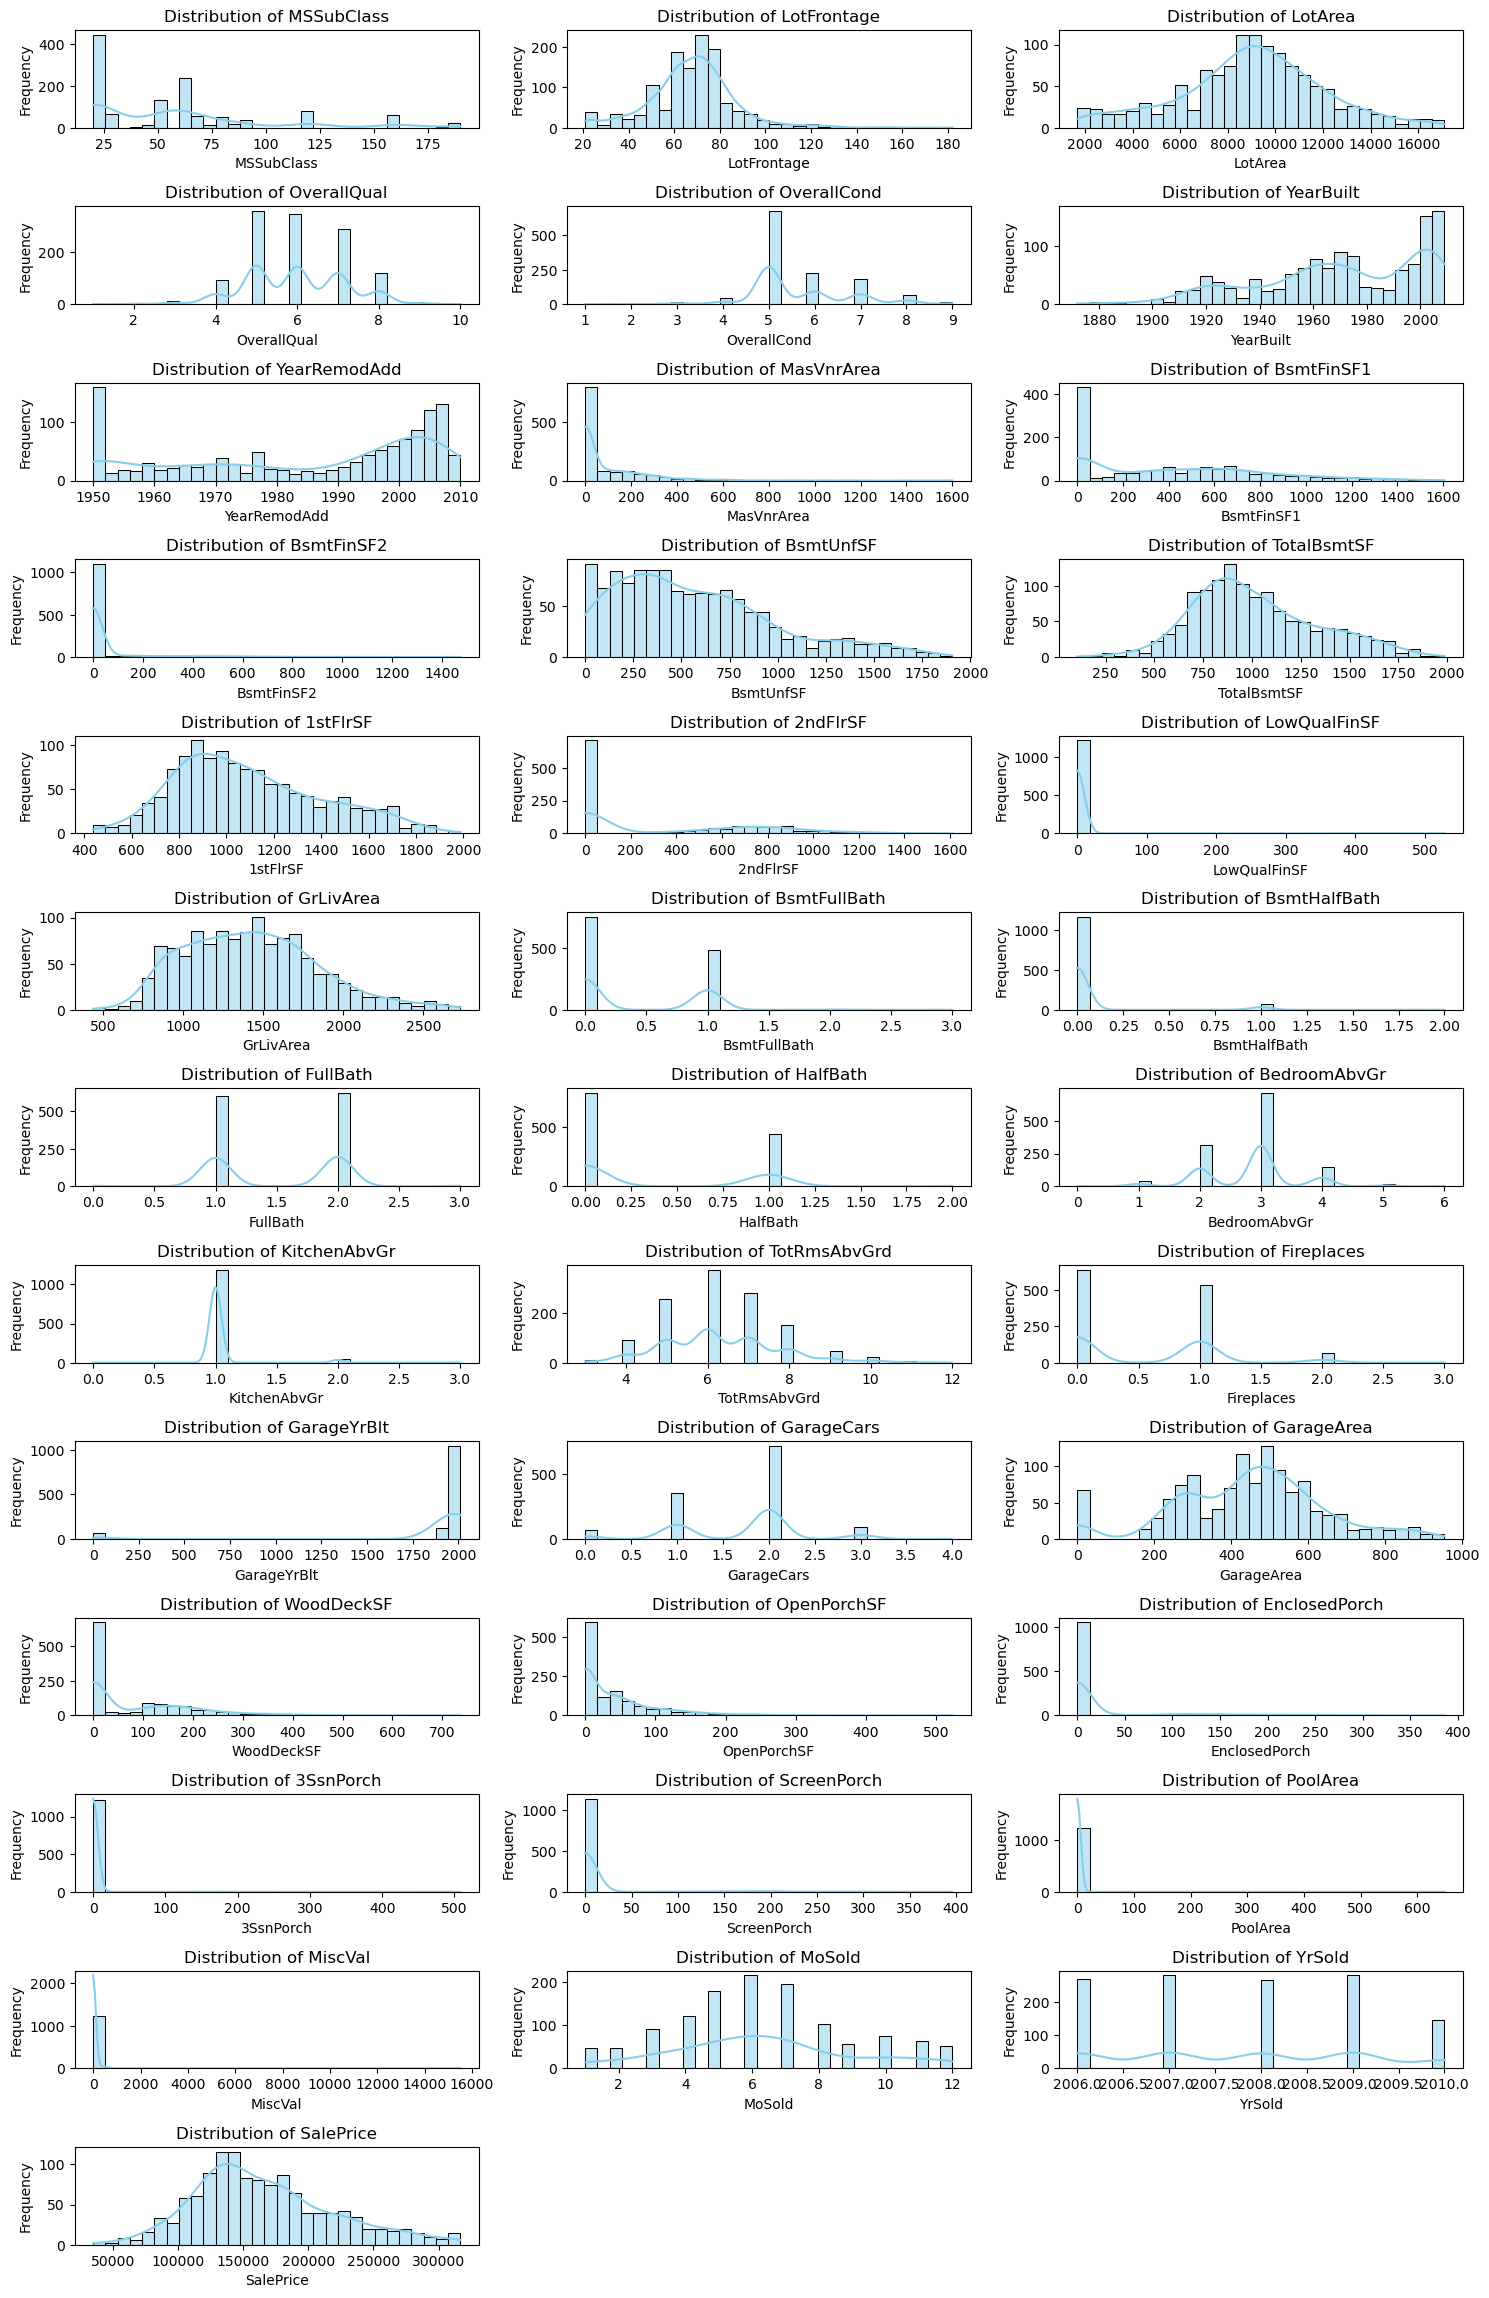

In [76]:
# Set up the plotting space
plt.figure(figsize=(15, 35))

# Plotting the distributions of each numerical column using seaborn
for i, col in enumerate(numerical_cols[1:]):
    # Skip numerical categories
    plt.subplot(20, 3, i + 1)  # Adjusting the subplot grid based on the number of columns
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## 1.7 Distribution of Ordinal Columns

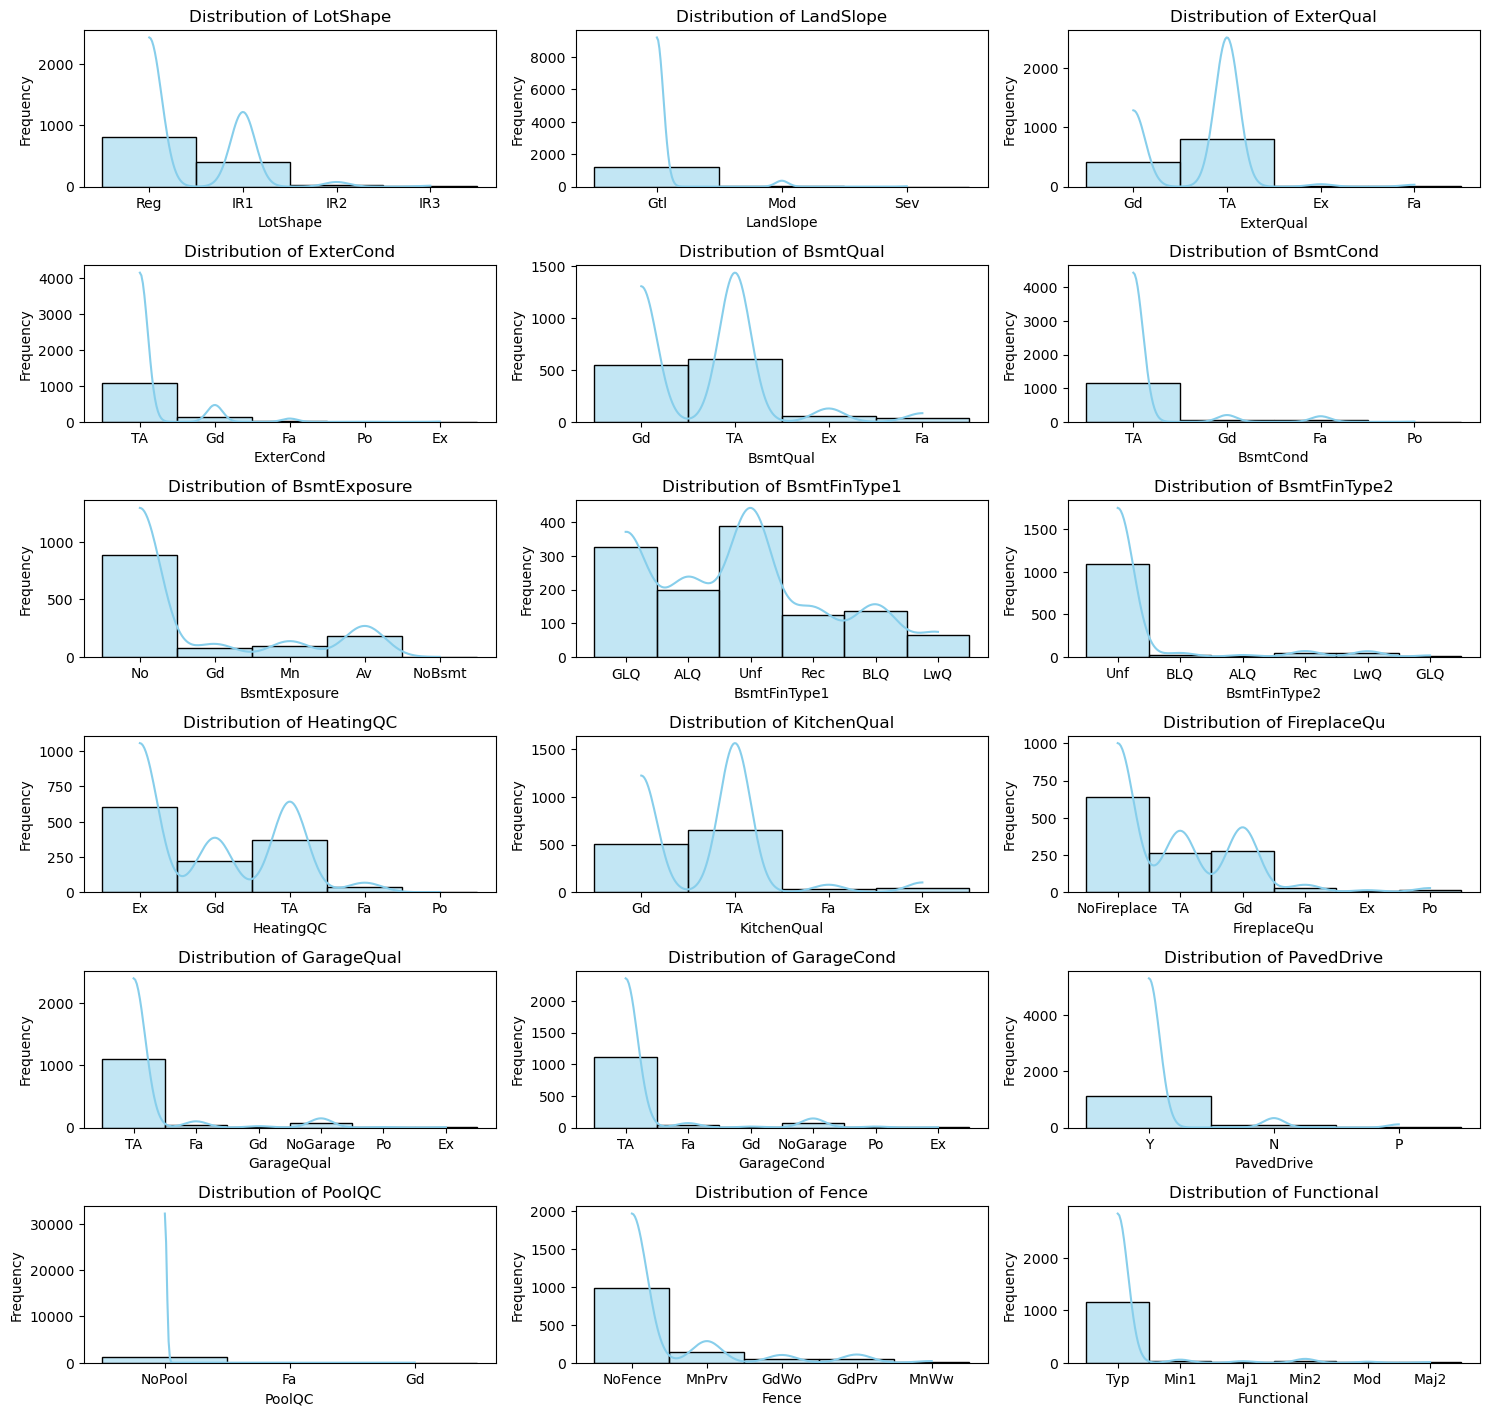

In [77]:
# Set up the plotting space
plt.figure(figsize=(15, 35))

# Plotting the distributions of each ordinal column using seaborn
for i, col in enumerate(df_ordinal_encoded.columns):
    plt.subplot(15, 3, i + 1)  # Adjusting the subplot grid based on the number of columns
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## 1.8 Distribution of Nominal Columns

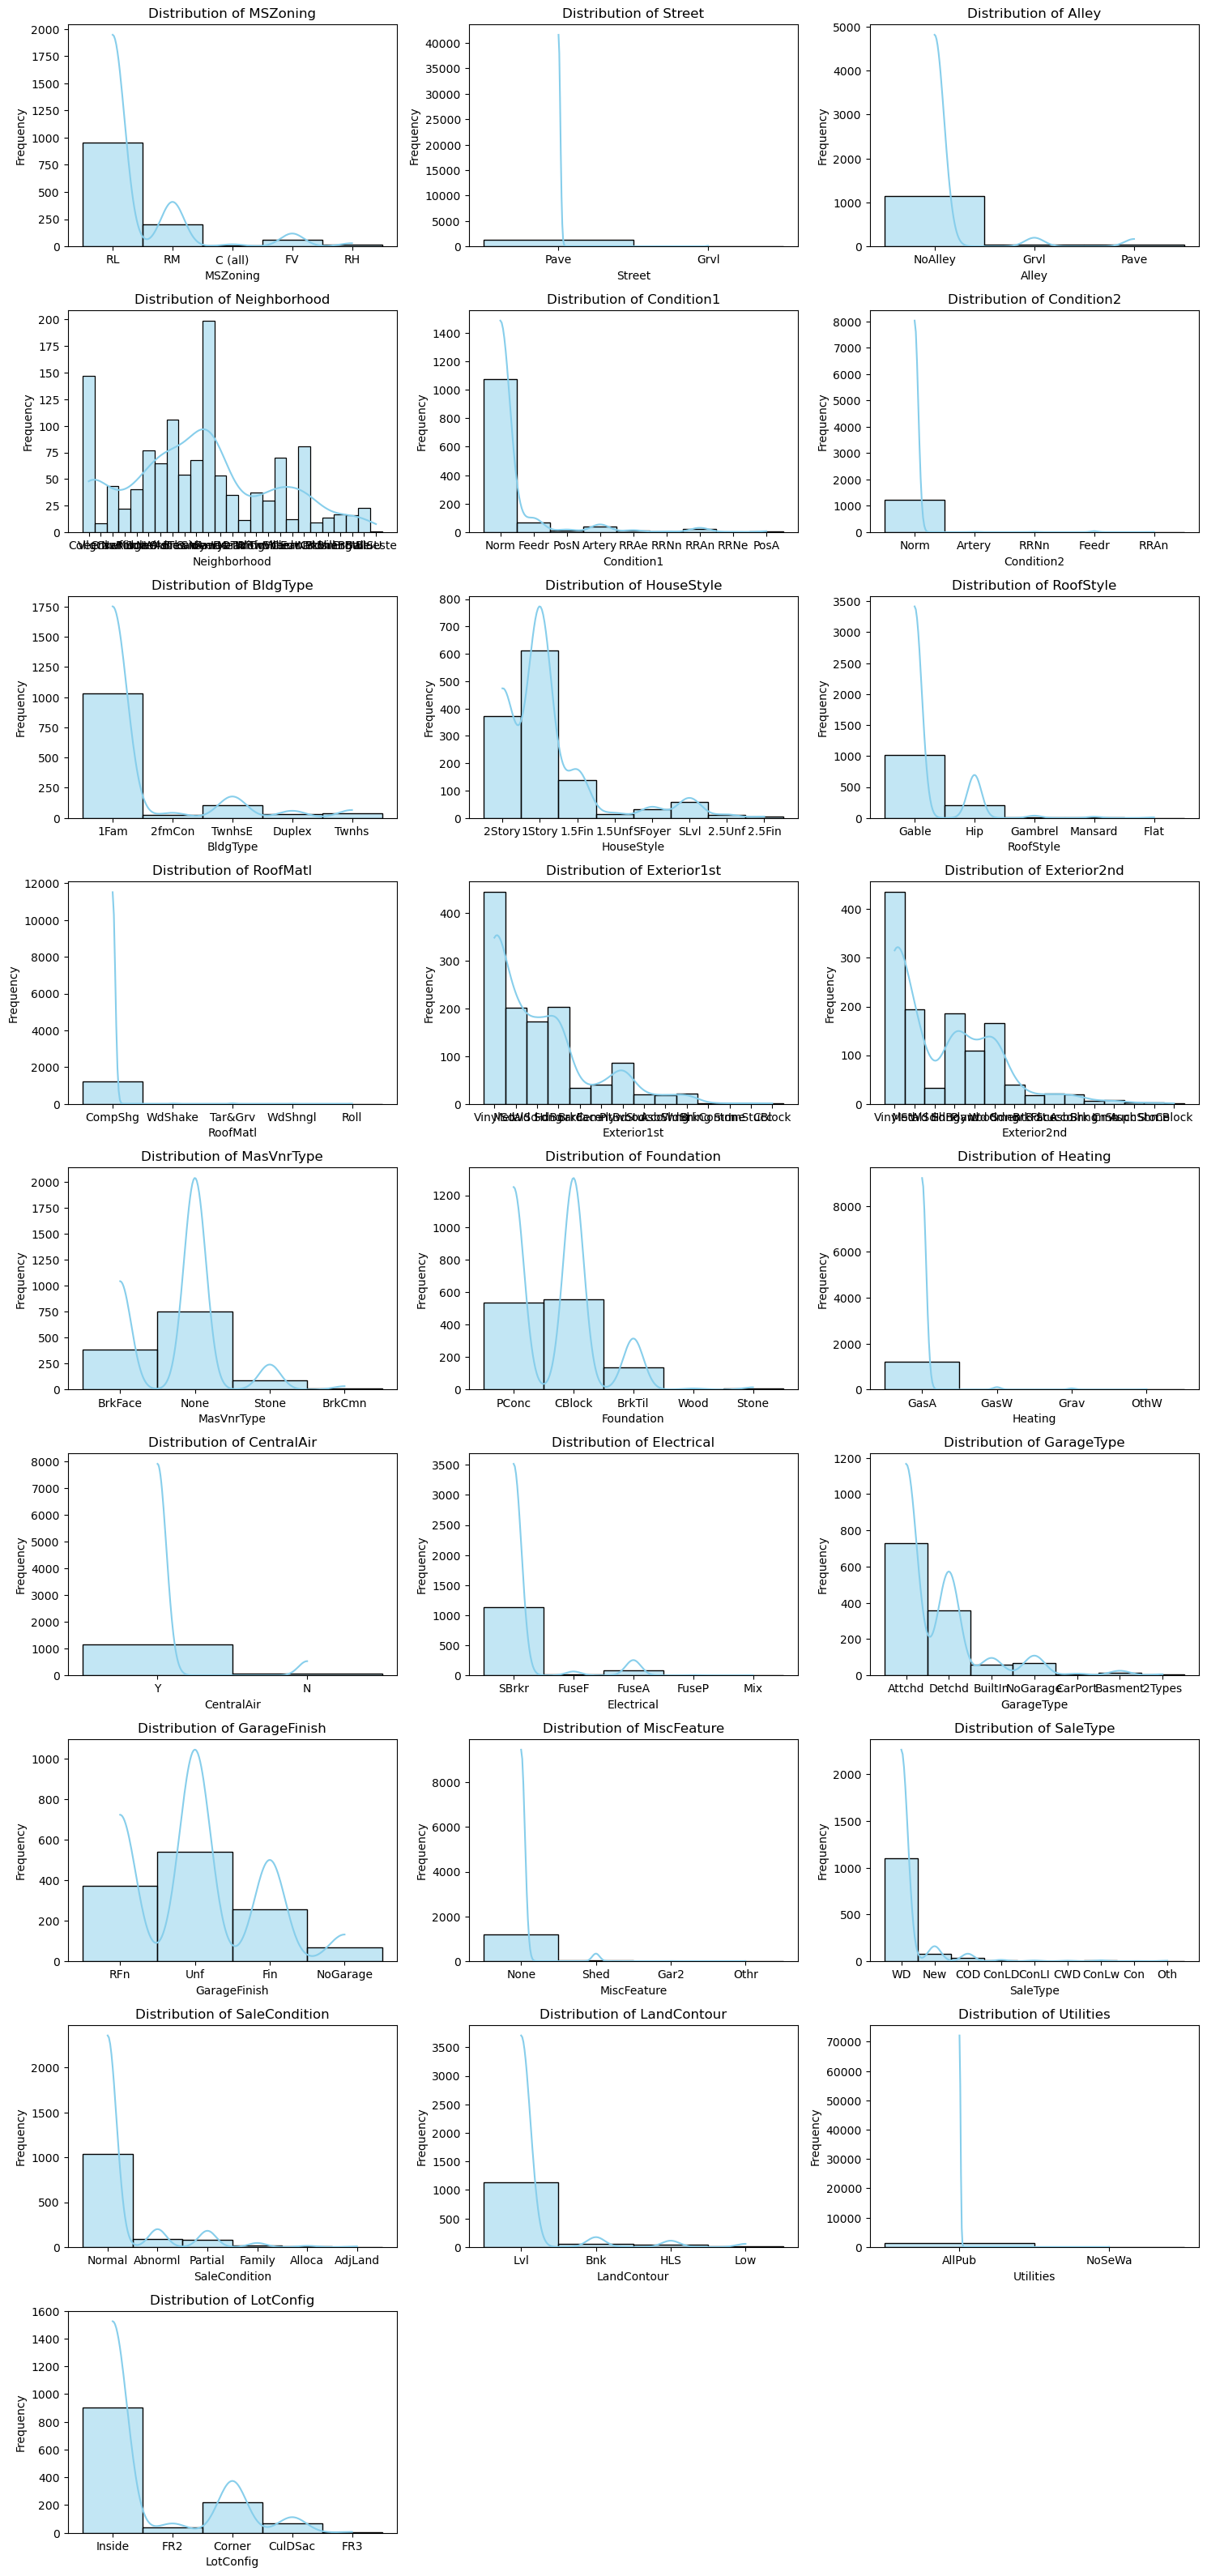

In [78]:
# Set up the plotting space
plt.figure(figsize=(15, 35))

# Plotting the distributions of each nominal column using seaborn
for i, col in enumerate(nominal_cols):
    plt.subplot(10, 3, i + 1)  # Adjusting the subplot grid based on the number of columns
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## 1.9 Correlations

### 1.9.1 Correlation Marix

In [79]:
# Compute the correlation matrix using Spearman correlation
corr_matrix = df_encoded.corr(method='spearman')

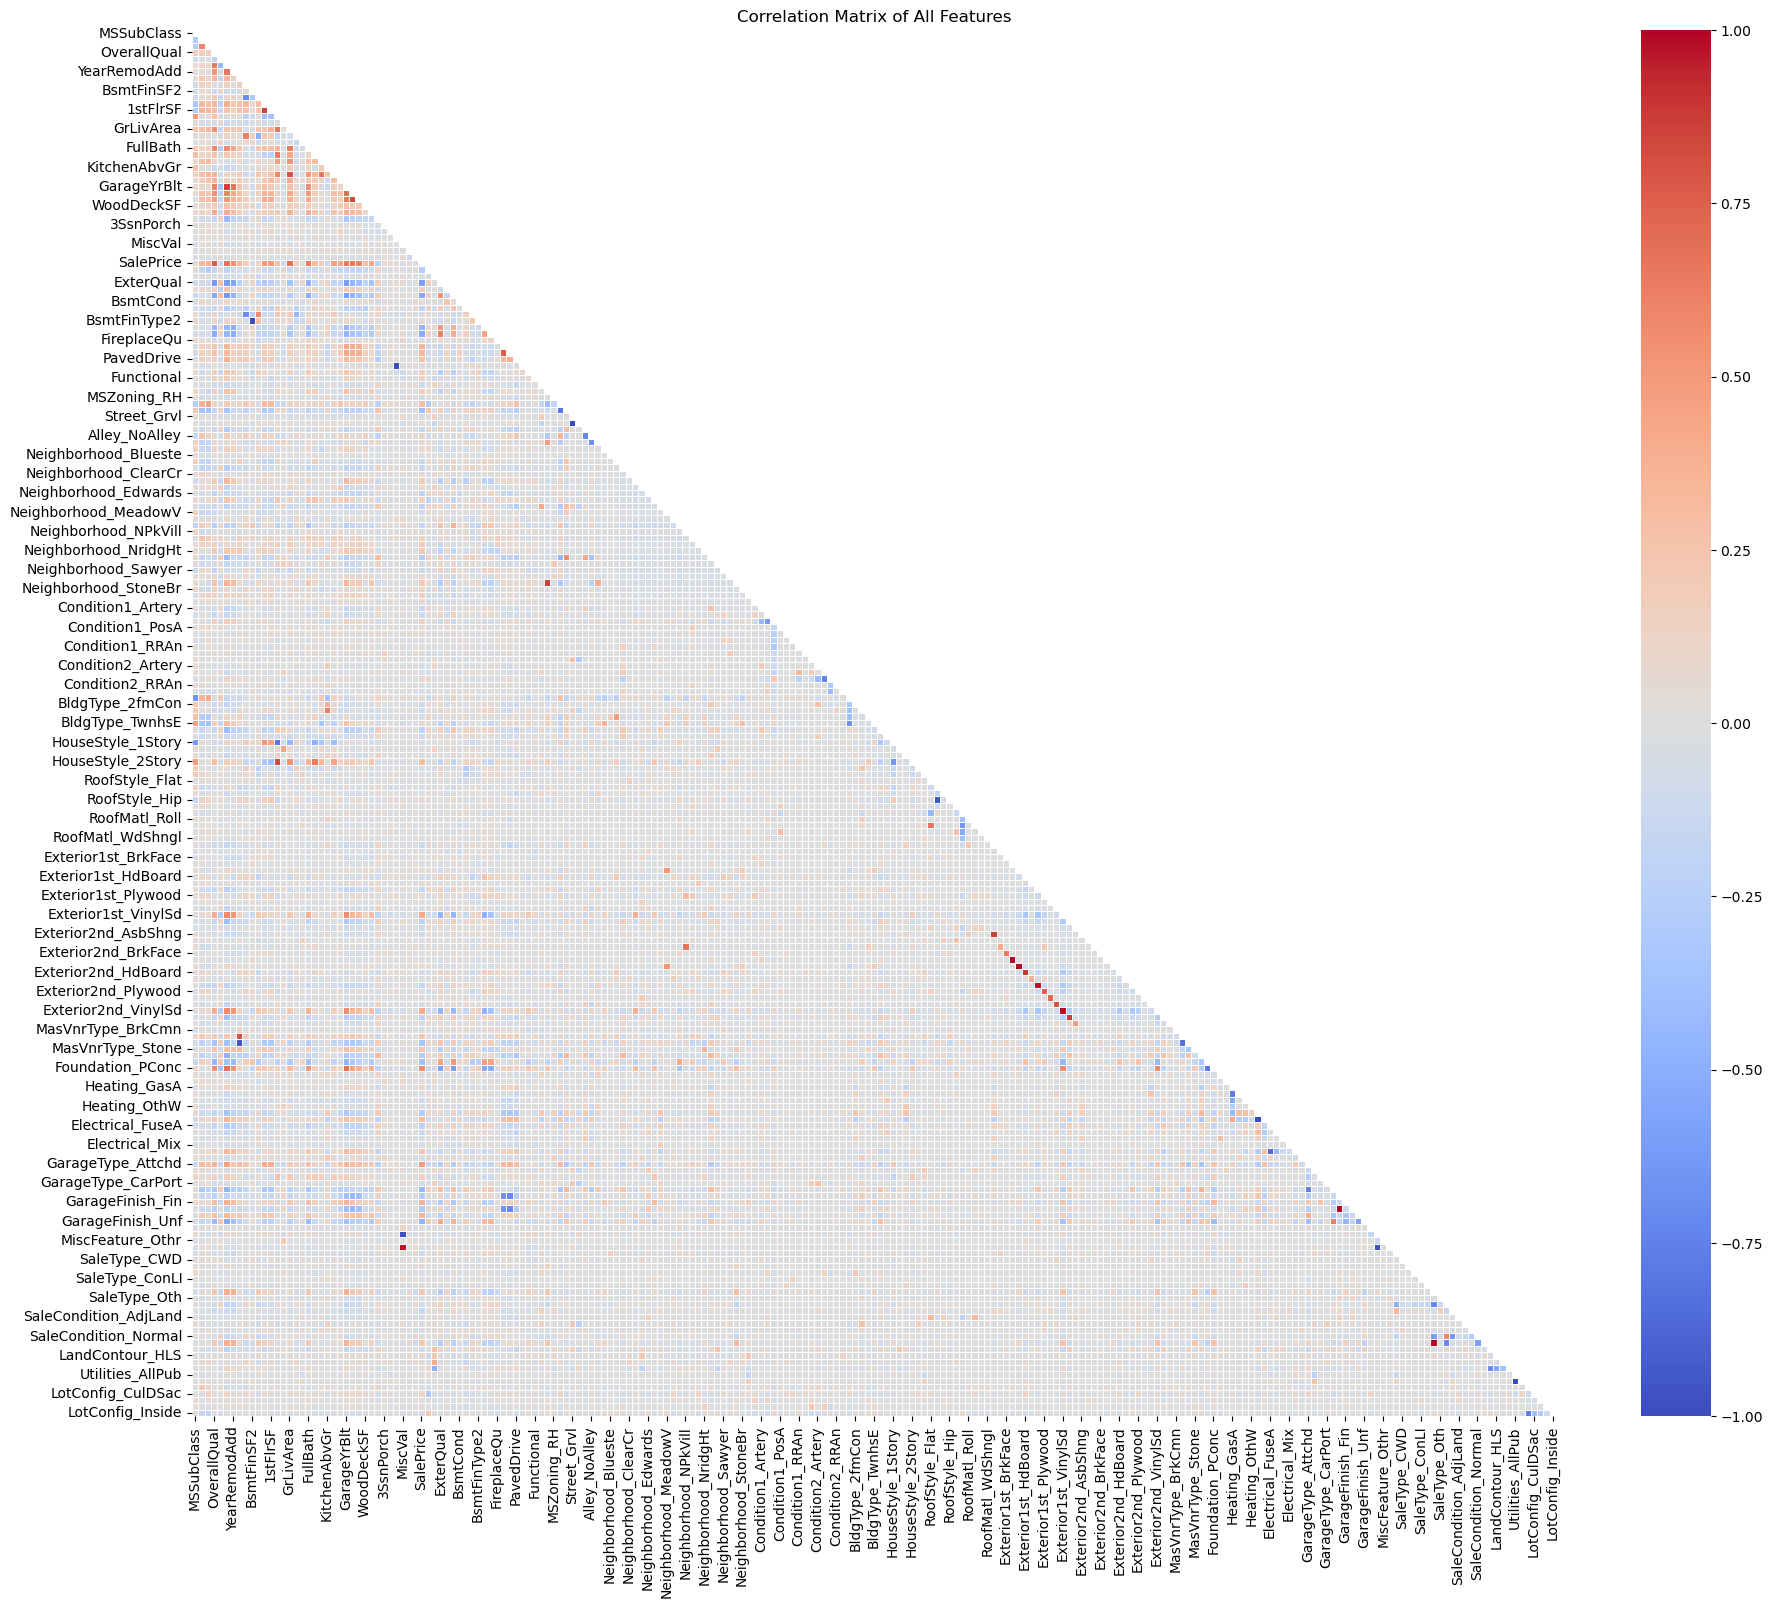

In [80]:
# Set up the figure
plt.figure(figsize=(22, 18))

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
                            
# Plot the heatmap using seaborn
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', fmt=".2f", cbar=True, linewidths=0.5)

# Customize the title and labels
plt.title("Correlation Matrix of All Features")
plt.show()

### 1.9.2 Top correlated features with SalePrice

In [81]:
# Extract correlations with the target variable 'SalePrice' and sort by absolute values
saleprice_corr = corr_matrix['SalePrice'].dropna().sort_values(key=abs, ascending=False)
top_features_corr = saleprice_corr.head(20)
# Display the top correlated features with SalePrice
print("Top correlations with SalePrice:")
print(top_features_corr)

Top correlations with SalePrice:
SalePrice            1.000000
OverallQual          0.779509
GrLivArea            0.681876
YearBuilt            0.673951
GarageCars           0.655978
FullBath             0.644729
GarageYrBlt          0.638193
GarageArea           0.605355
ExterQual           -0.604937
Foundation_PConc     0.567101
YearRemodAdd         0.564748
BsmtQual            -0.543980
KitchenQual         -0.535945
TotalBsmtSF          0.503579
1stFlrSF             0.502568
GarageFinish_Unf    -0.490638
GarageType_Attchd    0.486426
TotRmsAbvGrd         0.479851
HeatingQC           -0.470992
OpenPorchSF          0.460168
Name: SalePrice, dtype: float64


### 1.9.3 Top Correlated Pairs

In [82]:
# Find pairs of highly correlated features (absolute correlation > 0.75)
high_corr_pairs = corr_matrix.abs().stack().reset_index()
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']

# Filter pairs where the correlation is above 0.75 and not between the same features
high_corr_pairs = high_corr_pairs[
    (high_corr_pairs['Correlation'] > 0.75) & (high_corr_pairs['Feature1'] != high_corr_pairs['Feature2'])
]

# Drop duplicates by ensuring the pair order doesn't matter
high_corr_pairs['SortedFeatures'] = high_corr_pairs.apply(lambda x: tuple(sorted([x['Feature1'], x['Feature2']])), axis=1)
high_corr_pairs = high_corr_pairs.drop_duplicates(subset=['SortedFeatures'])

# Display highly correlated feature pairs
print("Highly correlated feature pairs (correlation > 0.75):")
print(high_corr_pairs[['Feature1', 'Feature2', 'Correlation']])

Highly correlated feature pairs (correlation > 0.75):
                  Feature1               Feature2  Correlation
687            OverallQual              SalePrice     0.779509
1109             YearBuilt            GarageYrBlt     0.861525
1676            MasVnrArea     MasVnrType_BrkFace     0.805012
1677            MasVnrArea        MasVnrType_None     0.957378
1998            BsmtFinSF2           BsmtFinType2     0.995806
2399           TotalBsmtSF               1stFlrSF     0.857771
2932              2ndFlrSF      HouseStyle_1Story     0.809832
2935              2ndFlrSF      HouseStyle_2Story     0.831982
3277             GrLivArea           TotRmsAbvGrd     0.806341
5451            GarageCars             GarageArea     0.837441
6996              PoolArea                 PoolQC     1.000000
7349               MiscVal       MiscFeature_None     0.976508
7351               MiscVal       MiscFeature_Shed     0.974892
10683           GarageQual             GarageCond     0.761000
1

## 1.10 Save Data

In [32]:
with open('df_df_encoded_cleaned_imputated.pkl','wb') as f:
    pickle.dump((df,df_encoded),f)

# 2. Baseline Models and Feature Importance
I like to train quick baseline models at this point before investing time in advanced analysis and feature engineering. Basic models sometimes works fine without doing fancy analysis so lets start here and then improve the reuslts, if need be, with feature engineering and selection and with fine tuning and advanced models

## 2.1 Split the train data into train and val

In [33]:
# Read data
with open('df_df_encoded_cleaned_imputated.pkl','rb') as f:
   _,df_all = pickle.load(f)

In [34]:
# # Retrieve the original training DataFrame using its original index
df_train_retrieved = df_all[df_all['Id'].isin(df_train['Id'])]
df_train_retrieved = df_train_retrieved.drop(['index','Id'], axis=1) 

# Retrieve the original test DataFrame using its original index
df_test_retrieved = df_all[df_all['Id'].isin(df_test['Id'])]
df_test_retrieved= df_test_retrieved.drop(['SalePrice','index','Id'], axis=1) 

## 2.2 Baseline models (All Features No Normalization)

In [36]:
X = df_train_retrieved.drop(['SalePrice'], axis=1)  # Features
y = df_train_retrieved['SalePrice']  # Target variable

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models including advanced regression techniques and polynomial regression
linear_model = LinearRegression()
ridge_model = Ridge(alpha=1.0)
lasso_model = Lasso(alpha=0.01)
elasticnet_model = ElasticNet(alpha=0.01, l1_ratio=0.5)
decision_tree = DecisionTreeRegressor(random_state=42)
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
gradient_boosting = GradientBoostingRegressor(n_estimators=100, random_state=42)
xgboost_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
lightgbm_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
catboost_model = CatBoostRegressor(verbose=0, random_state=42)

# Polynomial Regression with degree 2
poly_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('linear', LinearRegression())
])

# Create a dictionary of models
models = {
    'Linear Regression': linear_model, 
    'Ridge Regression': ridge_model, 
    'Lasso Regression': lasso_model,
    'ElasticNet Regression': elasticnet_model,
    'Decision Tree': decision_tree, 
    'Random Forest': random_forest,
    'Gradient Boosting': gradient_boosting,
    'XGBoost': xgboost_model,
    'LightGBM': lightgbm_model,
    'CatBoost': catboost_model,
    '2nd Degree Polynomial Regression': poly_pipeline
}

# Store results
results = {}

# Function to evaluate model performance on log-transformed targets
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name, dataset_type):
    # Train the model on the log-transformed target
    y_train_log = np.log1p(y_train)
    y_val_log = np.log1p(y_val)
    
    model.fit(X_train, y_train_log)
    
    # Predict on training set
    y_train_pred_log = model.predict(X_train)
    train_log_rmse = np.sqrt(mean_squared_error(y_train_log, y_train_pred_log))
    train_log_r2 = r2_score(y_train_log, y_train_pred_log)
    
    # Predict on validation set
    y_val_pred_log = model.predict(X_val)
    val_log_rmse = np.sqrt(mean_squared_error(y_val_log, y_val_pred_log))
    val_log_r2 = r2_score(y_val_log, y_val_pred_log)
    
    # Store results
    results[f'{model_name} ({dataset_type})'] = {
        'Train_log_RMSE': train_log_rmse, 'Train R²': train_log_r2,
        'Val_log_RMSE': val_log_rmse, 'Val R²': val_log_r2
    }
    
    # Print results
    print(f"{model_name} ({dataset_type}) - Train Logs RMSE: {train_log_rmse:.2f}, Train Logs R²: {train_log_r2:.2f}, "
          f"Val Logs RMSE: {val_log_rmse:.2f}, Val Logs R²: {val_log_r2:.2f}")

# Evaluate models on encoded data
print("\nResults on Encoded Data:")
for name, model in models.items():
    evaluate_model(model, X_train, y_train, X_val, y_val, name, 'Encoded')


Results on Encoded Data:
Linear Regression (Encoded) - Train Logs RMSE: 0.09, Train Logs R²: 0.92, Val Logs RMSE: 0.11, Val Logs R²: 0.86
Ridge Regression (Encoded) - Train Logs RMSE: 0.09, Train Logs R²: 0.92, Val Logs RMSE: 0.10, Val Logs R²: 0.87
Lasso Regression (Encoded) - Train Logs RMSE: 0.12, Train Logs R²: 0.86, Val Logs RMSE: 0.11, Val Logs R²: 0.86
ElasticNet Regression (Encoded) - Train Logs RMSE: 0.12, Train Logs R²: 0.87, Val Logs RMSE: 0.10, Val Logs R²: 0.87
Decision Tree (Encoded) - Train Logs RMSE: 0.00, Train Logs R²: 1.00, Val Logs RMSE: 0.19, Val Logs R²: 0.54
Random Forest (Encoded) - Train Logs RMSE: 0.05, Train Logs R²: 0.98, Val Logs RMSE: 0.11, Val Logs R²: 0.84
Gradient Boosting (Encoded) - Train Logs RMSE: 0.07, Train Logs R²: 0.96, Val Logs RMSE: 0.10, Val Logs R²: 0.87
XGBoost (Encoded) - Train Logs RMSE: 0.00, Train Logs R²: 1.00, Val Logs RMSE: 0.12, Val Logs R²: 0.81
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[Light

# 3. Feature Selection and Engineering

In [37]:
df = df_train_retrieved.copy()

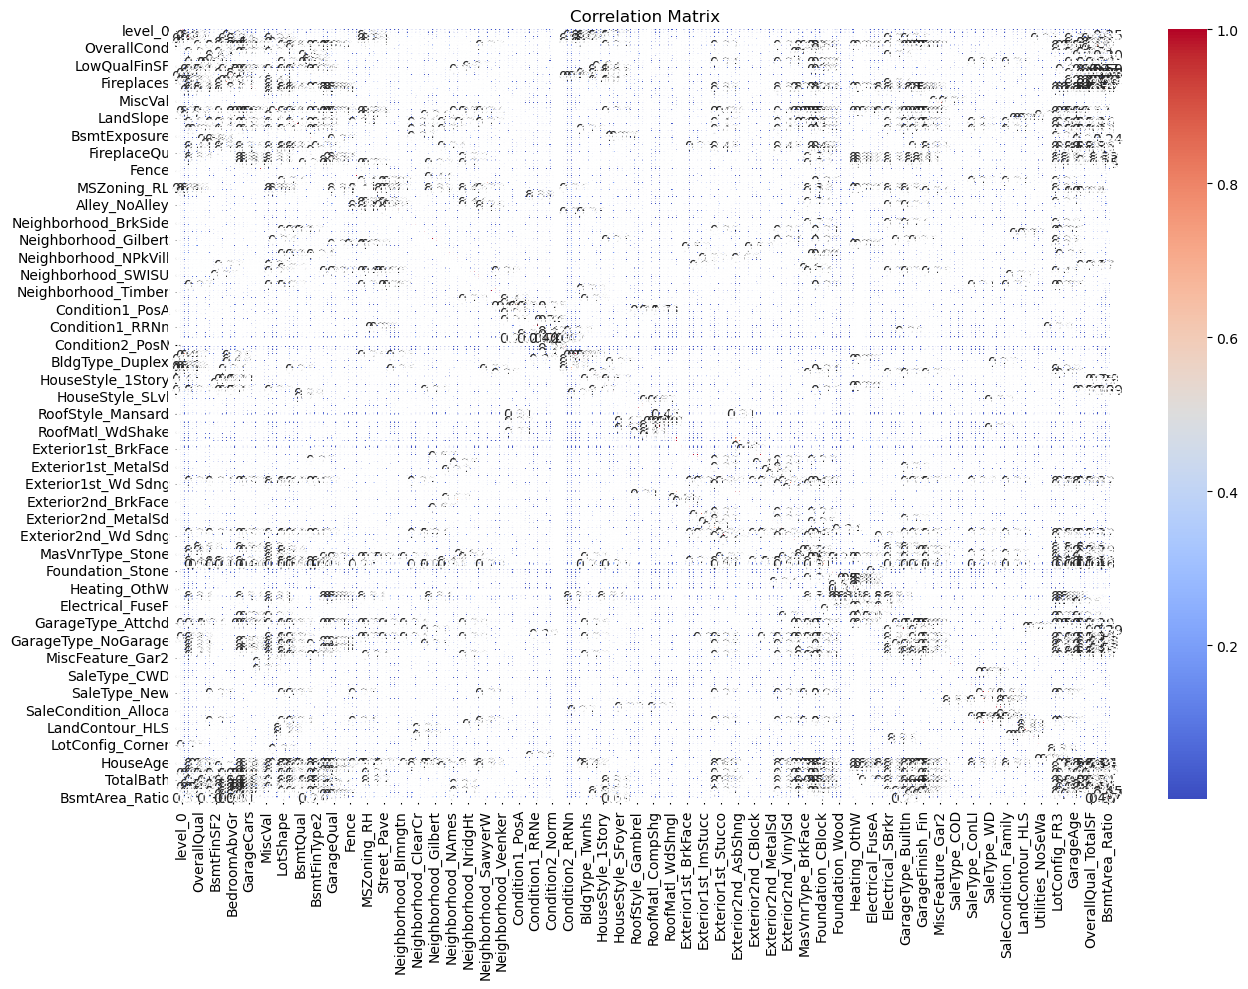

Selected Features: ['level_0', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'MoSold', 'YrSold', 'LotShape', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 'Functional', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RL', 'MSZoning_RM', 'Alley_Grvl', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_OldTown', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_RRAe', 'BldgType_1Fam', 'BldgType_Twnhs', 'HouseStyle_1.5Fin', 'HouseStyle_2Story', 'RoofStyle_Gable', 'Exterior1st_BrkFace', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_MetalSd', 

In [38]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Step 1: Create Advanced Engineered Features

# Age-related features
df['HouseAge'] = df['YrSold'] - df['YearBuilt']
df['RemodelAge'] = df['YrSold'] - df['YearRemodAdd']
df['GarageAge'] = df['YrSold'] - df['GarageYrBlt']

# Total and combined areas
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
df['TotalBath'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']

# Quality and condition combined features
df['OverallQual_TotalSF'] = df['OverallQual'] * df['TotalSF']
df['OverallCond_TotalSF'] = df['OverallCond'] * df['TotalSF']
df['GrLivArea_OverallQual'] = df['GrLivArea'] * df['OverallQual']

# Ratio features
df['GarageArea_Ratio'] = df['GarageArea'] / df['GrLivArea']
df['BsmtArea_Ratio'] = df['TotalBsmtSF'] / df['TotalSF']

# Drop original features that are redundant
df = df.drop(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', '1stFlrSF', '2ndFlrSF', 
              'TotalBsmtSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
              'ScreenPorch', 'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'], axis=1)

# Step 2: Correlation Analysis to Drop Highly Correlated Features
# Create a correlation matrix
corr_matrix = df.corr().abs()

# Plot heatmap for visualization
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

# Drop highly correlated features (threshold > 0.85)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
df = df.drop(to_drop, axis=1)

# Step 3: Feature Selection Using RandomForestRegressor
X = df.drop(['SalePrice'], axis=1)  # Features
y = df['SalePrice']  # Target variable

# Train a RandomForestRegressor to assess feature importance
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Select important features based on feature importance
selector = SelectFromModel(model, threshold='median', prefit=True)
selected_features = X.columns[(selector.get_support())]

# Keep only the selected features
X_selected = df[selected_features].copy()

# Display the selected features and their importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print("Selected Features:", selected_features.tolist())
print(feature_importances.head(20))  # Display the top 20 important features

In [39]:
# select_feature = list(feature_importances.head(20)['Feature'])

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# 4. Baseline Models With Engineered features

In [42]:

# Store results
results_engineered_features = {}

# Evaluate models on encoded data
print("\nResults on Encoded Data:")
for name, model in models.items():
    evaluate_model(model, X_train, y_train, X_val, y_val, name, 'Encoded')


Results on Encoded Data:
Linear Regression (Encoded) - Train Logs RMSE: 0.10, Train Logs R²: 0.91, Val Logs RMSE: 0.10, Val Logs R²: 0.87
Ridge Regression (Encoded) - Train Logs RMSE: 0.10, Train Logs R²: 0.91, Val Logs RMSE: 0.10, Val Logs R²: 0.87
Lasso Regression (Encoded) - Train Logs RMSE: 0.12, Train Logs R²: 0.85, Val Logs RMSE: 0.11, Val Logs R²: 0.86
ElasticNet Regression (Encoded) - Train Logs RMSE: 0.12, Train Logs R²: 0.86, Val Logs RMSE: 0.11, Val Logs R²: 0.86
Decision Tree (Encoded) - Train Logs RMSE: 0.00, Train Logs R²: 1.00, Val Logs RMSE: 0.18, Val Logs R²: 0.61
Random Forest (Encoded) - Train Logs RMSE: 0.05, Train Logs R²: 0.98, Val Logs RMSE: 0.11, Val Logs R²: 0.86
Gradient Boosting (Encoded) - Train Logs RMSE: 0.07, Train Logs R²: 0.96, Val Logs RMSE: 0.10, Val Logs R²: 0.87
XGBoost (Encoded) - Train Logs RMSE: 0.00, Train Logs R²: 1.00, Val Logs RMSE: 0.12, Val Logs R²: 0.83
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[Light

# 4. Fine Tuning CatBoost Model

In [44]:
# Define parameter grid for CatBoost tuning
param_grid = {
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
    'n_estimators': [100, 300, 500, 700, 1000],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'subsample': [0.8, 0.9, 1.0]
}

# Initialize CatBoost model for tuning
catboost_tuning_model = CatBoostRegressor(verbose=0, random_state=42)

# Set up RandomizedSearchCV with cross-validation
random_search = RandomizedSearchCV(
    estimator=catboost_tuning_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings to sample
    scoring='neg_root_mean_squared_error',  # RMSE for evaluation
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Log-transform the target variables
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

X_train, X_val, y_train, y_val = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Fit the RandomizedSearchCV on training data with log-transformed target
random_search.fit(X_train, y_train_log)

# Retrieve the best parameters found by RandomizedSearchCV
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Retrieve the best model
best_catboost_model = random_search.best_estimator_

# Evaluate the best model on the training set
y_train_pred_log = best_catboost_model.predict(X_train)
train_log_rmse = np.sqrt(mean_squared_error(y_train_log, y_train_pred_log))
train_log_r2 = r2_score(y_train_log, y_train_pred_log)
print(f"Best CatBoost Model - Training Logs RMSE: {train_log_rmse:.2f}, Training Logs R²: {train_log_r2:.2f}")

# Evaluate the best model on the validation set
y_val_pred_log = best_catboost_model.predict(X_val)
val_log_rmse = np.sqrt(mean_squared_error(y_val_log, y_val_pred_log))
val_log_r2 = r2_score(y_val_log, y_val_pred_log)
print(f"Best CatBoost Model - Validation Logs RMSE: {val_log_rmse:.2f}, Validation Logs R²: {val_log_r2:.2f}")

# Transform predictions back to the original scale for validation
y_val_pred = np.expm1(y_val_pred_log)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print(f"Best CatBoost Model - Validation Set RMSE: {val_rmse:.2f}, Validation Set R²: {val_r2:.2f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 1000, 'learning_rate': 0.05, 'l2_leaf_reg': 1, 'depth': 6}
Best CatBoost Model - Training Logs RMSE: 0.01, Training Logs R²: 1.00
Best CatBoost Model - Validation Logs RMSE: 0.10, Validation Logs R²: 0.87
Best CatBoost Model - Validation Set RMSE: 15151.08, Validation Set R²: 0.88


# 5. Final Model Save before Deployment

In [50]:
# Combine training and validation data for final training
X_final = pd.concat([X_train, X_val], axis=0)
y_final = pd.concat([y_train, y_val], axis=0)

# Identify numerical columns
numerical_cols = X_final.select_dtypes(include=['int64', 'float64']).columns

# Initialize the scaler and fit-transform on the combined data
scaler = StandardScaler()
X_final_scaled = X_final.copy()
X_final_scaled[numerical_cols] = scaler.fit_transform(X_final[numerical_cols])

# Best parameters identified during tuning
best_params = {
    'iterations': 1000,
    'depth': 6,
    'learning_rate': 0.05,
    'l2_leaf_reg': 1,
    'subsample': 0.8,
    'verbose': 0,
    'random_state': 42
}

# Initialize and train the final CatBoost model
final_catboost_model = CatBoostRegressor(**best_params)
y_final_log = np.log1p(y_final)
final_catboost_model.fit(X_final_scaled, y_final_log, verbose=0)

# Evaluate the model on the training set to verify fit
y_final_pred_log = final_catboost_model.predict(X_final_scaled)
final_log_rmse = np.sqrt(mean_squared_error(y_final_log, y_final_pred_log))
final_log_r2 = r2_score(y_final_log, y_final_pred_log)
print(f"Final CatBoost Model - Combined Logs RMSE: {final_log_rmse:.2f}, Combined Logs R²: {final_log_r2:.2f}")

# Transform predictions back to the original scale
y_final_pred = np.expm1(y_final_pred_log)
final_rmse = np.sqrt(mean_squared_error(y_final, y_final_pred))
final_r2 = r2_score(y_final, y_final_pred)

print(f"Final CatBoost Model - Combined Set RMSE: {final_rmse:.2f}, Combined Set R²: {final_r2:.2f}")

# Save the final model for future predictions
final_catboost_model.save_model('final_catboost_model.cbm')
joblib.dump(final_catboost_model, 'final_catboost_model.pkl')

Final CatBoost Model - Combined Logs RMSE: 0.02, Combined Logs R²: 1.00
Final CatBoost Model - Combined Set RMSE: 2582.72, Combined Set R²: 1.00


['final_catboost_model.pkl']